In this document we add batch normalisation, dropout regularisation and data augmentation to the original code, as per ***SOURCE!***. We also increase the number of epochs in training.



In [1]:
import torch #creates/trains models and performs tensor operations
import torchvision #gives popular datasets, model architectures and image processing stuff
import torchvision.transforms as transforms #helps preprocess images to help model use them
import matplotlib.pyplot as plt
import numpy as np

**Data Augmentation**

In the below cell we adapt the 'transform' function from the original code. Before, its purpose was just to transform the input to a PyTorch Tensor and normalise the values so that we could work with the data. Now, we use it for 'data augmentation' - randomly altering the images in various ways including rotations, cropping and colour changes. The idea is to force the model to learn significant features of the images, rather than overfitting to other features of the data. As an example of this, the pictures with the planes have a blue sky in the background. In the original, it's likely that the model partly classifies planes based on the specific shade and number of blue pixels in the image. However this could lead to problems, for example if the model was fed an image of a dog with a blue background. Altering the images forces the model to make classifications based on a *range* of features. When we alter the colour of the picture of the plane, the model can no longer rely on blue pixels to classify the plane. Therefore it has to base its decision based on a more varied set of features, and focus more on the key classification indicators. This should improve robustness and reduce overfitting. This means the new model should do a better job of classifying images *outside* of the training set. However, the initial training will be slower, since the augmented images are less thematic and it will be harder for the model to find similarities between equivalent labelled images.



In [2]:
batch_size = 10
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),   #flips image with 50% probability
    transforms.RandomRotation(20),       #rotates image either +20 or -20 degrees
    transforms.RandomCrop(32, padding=3),#this adds 'padding' (adds a border of 3 black pixels to the image) and then selects a random 32x32 section
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # random color changes
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # normalising as before
])
transform_test = transforms.Compose([  #we keep the old transformations on the test set
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

**Downloading and loading augmented Dataset**

In [3]:
print("Downloading training data...")
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train) #we apply the new augmented transformation to the training set
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

print("Downloading testing data...")
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test) #and apply a non-augmenting transform to the test set
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

100%|██████████| 170M/170M [00:02<00:00, 74.9MB/s]


In [4]:
print(testset.transform)

Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)


The above downloads and loads the CIFAR-10 dataset, and augments the data in the training set. It doesn't augment the data in the testing set, since we still want to test the performance on the regular data.

In [5]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
traindataiter = iter(trainloader)
images, labels = next(traindataiter)

**Visualising images**

We check that the images have been altered correctly:

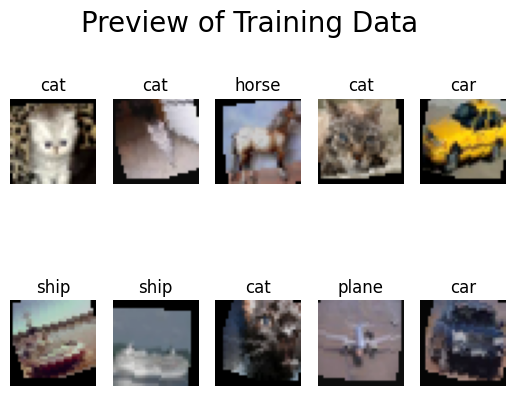

In [6]:
for i in range(batch_size):
    plt.subplot(2, int(batch_size/2), i + 1) #creates subplots
    img = images[i] #extracts each image
    img = img / 2 + 0.5 #undoes normalisation to restore original colour range
    npimg = img.numpy() #convert tensor to numpy array so we can plot with matplotlib
    plt.imshow(np.transpose(npimg, (1, 2, 0))) #adjusts image dimensions
    plt.axis('off')
    plt.title(classes[labels[i]]) #labels subplots

plt.suptitle('Preview of Training Data', size=20)
plt.show()

We can now see that the data augmentation has made the training data much more irregular and hard to recognise.

Let's also check that the testing set has been altered as we intended.

In [7]:
testdataiter = iter(testloader)
images, labels = next(testdataiter)

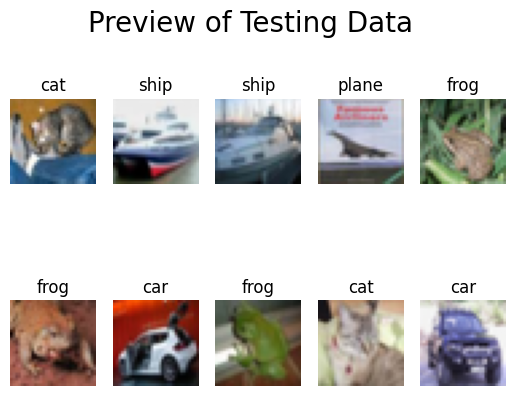

In [8]:
for i in range(batch_size):
    plt.subplot(2, int(batch_size/2), i + 1) #creates subplots
    img = images[i] #extracts each image
    img = img / 2 + 0.5 #undoes normalisation to restore original colour range
    npimg = img.numpy() #convert tensor to numpy array so we can plot with matplotlib
    plt.imshow(np.transpose(npimg, (1, 2, 0))) #adjusts image dimensions
    plt.axis('off')
    plt.title(classes[labels[i]]) #labels subplots

plt.suptitle('Preview of Testing Data', size=20)
plt.show()

So we have successfully separated testing and training data and modified them accordingly.

**Updating the architecture: Adding Batch Normalisation and Dropout Regularisation**

In the new architecture, we have added batch normalisation. Batch normalisation is performed between convolution/FC layers and activation layers, but *not* after ...

We use two different functions for batchnorm: BatchNorm1d and BatchNorm2d. They still perform the same task but they operate on different tensor shapes, since fully connected layers and convolution layers have different output shapes. Note that we don't apply batch normalisation after pooling layers or on the output, since that would just add noise.

We have *also* added dropout regularisation, but *only* to the fully connected layers, not the convolutional layers.

Generally, dropout isn't as useful in convolutional layers since most of the overfitting happens in fully connected layers (there are many more weights there - for example fc1 has 16x5x5x120=48000 while conv1 only has 3x6x5x5 = 450). Some CNNs use dropout in convolutional layers but many others don't. For example, ResNet doesn't.

Moreover, dropout would be especially harmful to this CNN because the feature maps are small. Dropping elements would leave the CNN with too little information and confuse the model. When we examined the training set images earlier, they are already low enough resolution that they are just recognisable. After pooling layers, even less information is left and so dropping elements would make the images near unrecognisable.

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # First defining layers
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.bn1 = nn.BatchNorm2d(6)

        self.pool = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(6, 16, 5)
        self.bn2 = nn.BatchNorm2d(16)

        # Fully connected layers
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.bn3 = nn.BatchNorm1d(120)

        self.fc2 = nn.Linear(120, 84)
        self.bn4 = nn.BatchNorm1d(84)

        self.fc3 = nn.Linear(84, 10)

        # Dropout layers
        self.dropout1 = nn.Dropout(p=0.5)
        self.dropout2 = nn.Dropout(p=0.5)


    def forward(self, x):
        # Conv block 1
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool(x)

        # Conv block 2
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool(x)

        # Flattening
        x = torch.flatten(x, 1)

        # Fully connected block 1
        x = self.fc1(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.dropout1(x)

        # Fully connected block 2
        x = self.fc2(x)
        x = self.bn4(x)
        x = F.relu(x)
        x = self.dropout2(x)

        # Output layer
        x = self.fc3(x)

        return x

**Training the Neural Network**

**Prepare for Training**

In [10]:
net = Net()

# Define a loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


print("Your network is ready for training!")

Your network is ready for training!


**Training and saving the model**

In [11]:
from tqdm import tqdm

EPOCHS = 5 #increased number of epochs
print("Training...")
for epoch in range(EPOCHS):
    running_loss = 0.0
    for i, data in enumerate(tqdm(trainloader, desc=f"Epoch {epoch + 1} of {EPOCHS}", leave=True, ncols=80)):
        inputs, labels = data

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

# Save our trained model
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

Training...


Epoch 5 of 5: 100%|█████████████████████████| 5000/5000 [01:26<00:00, 57.94it/s]


**Testing the model**

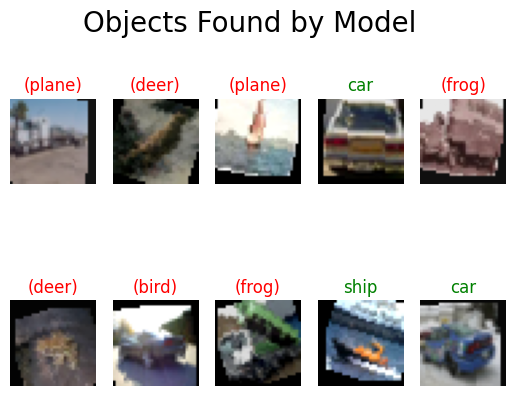

In [12]:
# Pick random photos from training set
if traindataiter == None:
    traindataiter = iter(trainloader)
images, labels = next(traindataiter)

# Load our model
net = Net()
net.load_state_dict(torch.load(PATH))

# Analyze images
outputs = net(images)
_, predicted = torch.max(outputs, 1)

# Show results
for i in range(batch_size):
    # Add new subplot
    plt.subplot(2, int(batch_size/2), i + 1)
    # Plot the image
    img = images[i]
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    # Add the image's label
    color = "green"
    label = classes[predicted[i]]
    if classes[labels[i]] != classes[predicted[i]]:
        color = "red"
        label = "(" + label + ")"
    plt.title(label, color=color)

plt.suptitle('Objects Found by Model', size=20)
plt.show()

**Evaluating model accuracy**

In [13]:
# Measure accuracy for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# Print accuracy statistics
accuracies = []
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    accuracies.append(accuracy)
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

average_accuracy = sum(accuracies) / len(accuracies)
print(f'\nAverage accuracy over all classes: {average_accuracy:.1f} %') #we  add some code to measure overall accuracy as our baseline performance metric

Accuracy for class: plane is 48.2 %
Accuracy for class: car   is 58.4 %
Accuracy for class: bird  is 28.7 %
Accuracy for class: cat   is 19.7 %
Accuracy for class: deer  is 31.3 %
Accuracy for class: dog   is 37.0 %
Accuracy for class: frog  is 60.1 %
Accuracy for class: horse is 56.0 %
Accuracy for class: ship  is 55.9 %
Accuracy for class: truck is 52.8 %

Average accuracy over all classes: 44.8 %


The accuracy over all classes has actually dropped from 50% to 45%. There's a couple of possible reasons for this, which we can tweak in subsequent models. Firstly, data augmentation could have slowed down the initial learning process as anticipated earlier. But we *have* increased the number of epochs accordingly so this shouldn't have caused such a massive performance drop. It might be worth reducing the noise slightly to improve initial learning. Another possible reason is the combination of batch normalisation and dropout regularisation. Since both of these normalise the data, it may end up overnormalised, which could also slow learning. The learning rate is also still quite low (lr=0.001), so it might be worth increasing this or trying a different optimiser that learns faster with less training.